In [1]:
import xarray as xr
import wandb
import numpy as np
import yaml
from utils import wandb_to_xarray
from constants import WANDB_ENTITY, WANDB_PROJECT
import matplotlib.pyplot as plt
import seaborn
plt.rcParams['figure.dpi'] = 300

In [2]:
VARIABLES = ['PRESsfc', 'surface_pressure_due_to_dry_air', 'total_water_path', 'PRATEsfc', 'LHTFLsfc']
METRICS = [f"inference/time_mean/{reduction}/{variable}" for variable in VARIABLES for reduction in ['rmse', 'bias']]
TIMESERIES_VARIABLES = ['surface_pressure_due_to_dry_air', 'total_water_path_budget_residual']
TIMESERIES_METRICS = [f"inference/mean/weighted_mean_gen/{variable}" for variable in TIMESERIES_VARIABLES]
RUN_NAMES = ['No constraints', 'Dry air', 'Dry air + moisture']
RUN_NAME_TO_BEAKER_NAME = {
    'No constraints': 'no-constraints',
    'Dry air': 'dry-air',
    'Dry air + moisture': 'dry-air-and-moisture',
}
IC_TAGS = ['IC0', 'IC1', 'IC2']

UNITS = {
    'PRESsfc': 'Pa', 
    'surface_pressure_due_to_dry_air': 'Pa', 
    'total_water_path': 'kg/m$^2$', 
    'PRATEsfc': 'mm/day', 
    'LHTFLsfc': 'W/m$^2$',
    'total_water_path_budget_residual': 'mm/day',
    'evaporation': 'mm/day',
}
LONG_NAMES = {
    'PRESsfc': 'Surface pressure',
    'surface_pressure_due_to_dry_air': '$< p_s^{dry} >$',
    'total_water_path': 'Total water path',
    'PRATEsfc': 'Surface precipitation',
    'LHTFLsfc': 'Latent heat flux',
    'total_water_path_budget_residual': '$< \partial{TWP}/\partial{t} |_{res} >$',
    'evaporation': 'Surface evaporation',
}

In [3]:
with open("wandb_ids.yaml", 'r') as f:
    wandb_ids = yaml.safe_load(f)

In [4]:
api = wandb.Api()

### Load time-mean metrics

In [5]:
ds = []
for run in RUN_NAMES:
    beaker_run_name = RUN_NAME_TO_BEAKER_NAME[run]
    ds_run = []
    for ic in IC_TAGS:
        run_name = f"shield-amip-{beaker_run_name}-10yr-{ic}-rerun"
        id = wandb_ids[run_name]
        ds_run.append(wandb_to_xarray(WANDB_PROJECT, id, METRICS, 1).assign_coords(ic=ic))
    ds.append(xr.concat(ds_run, dim='ic').assign_coords(run=run))
ds = xr.concat(ds, dim='run')
ds = ds.isel(lead_time=0).squeeze()
ds = ds.rename({k: '/'.join(k.split('/')[2:]) for k in ds.data_vars})

for metric in ['bias', 'rmse']:
    ds[f'{metric}/PRATEsfc'] *= 86400
    ds[f'{metric}/evaporation'] = ds[f'{metric}/LHTFLsfc'] / 2.5e6 * 86400

    for var in VARIABLES:
        ds[f'{metric}/{var}'].attrs['units'] = UNITS[var]
        ds[f'{metric}/{var}'].attrs['long_name'] = LONG_NAMES[var]

### Load time series metrics

In [6]:
TIMESERIES_METRICS

['inference/mean/weighted_mean_gen/surface_pressure_due_to_dry_air',
 'inference/mean/weighted_mean_gen/total_water_path_budget_residual']

In [7]:
N_STEPS = 4000
ds_timeseries = []
for run in RUN_NAMES:
    beaker_run_name = RUN_NAME_TO_BEAKER_NAME[run]
    ic = 'IC0'
    run_name = f"shield-amip-{beaker_run_name}-10yr-{ic}-rerun"
    id = wandb_ids[run_name]
    wandb_run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{id}")
    history = wandb_run.scan_history(keys=TIMESERIES_METRICS, max_step=N_STEPS)
    tmp = xr.Dataset()
    tmp['lead_time'] = np.arange(0, N_STEPS/4, 0.25)
    tmp['lead_time'].attrs['long_name'] = 'Time'
    tmp['lead_time'].attrs['units'] = 'days since init'
    for metric in TIMESERIES_METRICS:
        tmp[metric] = xr.DataArray([row[metric] for row in history], dims=['lead_time'])
    ds_timeseries.append(tmp.assign_coords(run=run))
ds_timeseries = xr.concat(ds_timeseries, dim='run')
ds_timeseries = ds_timeseries.rename({k: k.split('/')[-1] for k in ds_timeseries.data_vars})

ds_timeseries['total_water_path_budget_residual'] *= 86400

for var in TIMESERIES_VARIABLES:
    ds_timeseries[var].attrs['units'] = UNITS[var]
    ds_timeseries[var].attrs['long_name'] = LONG_NAMES[var]

## Plot timeseries

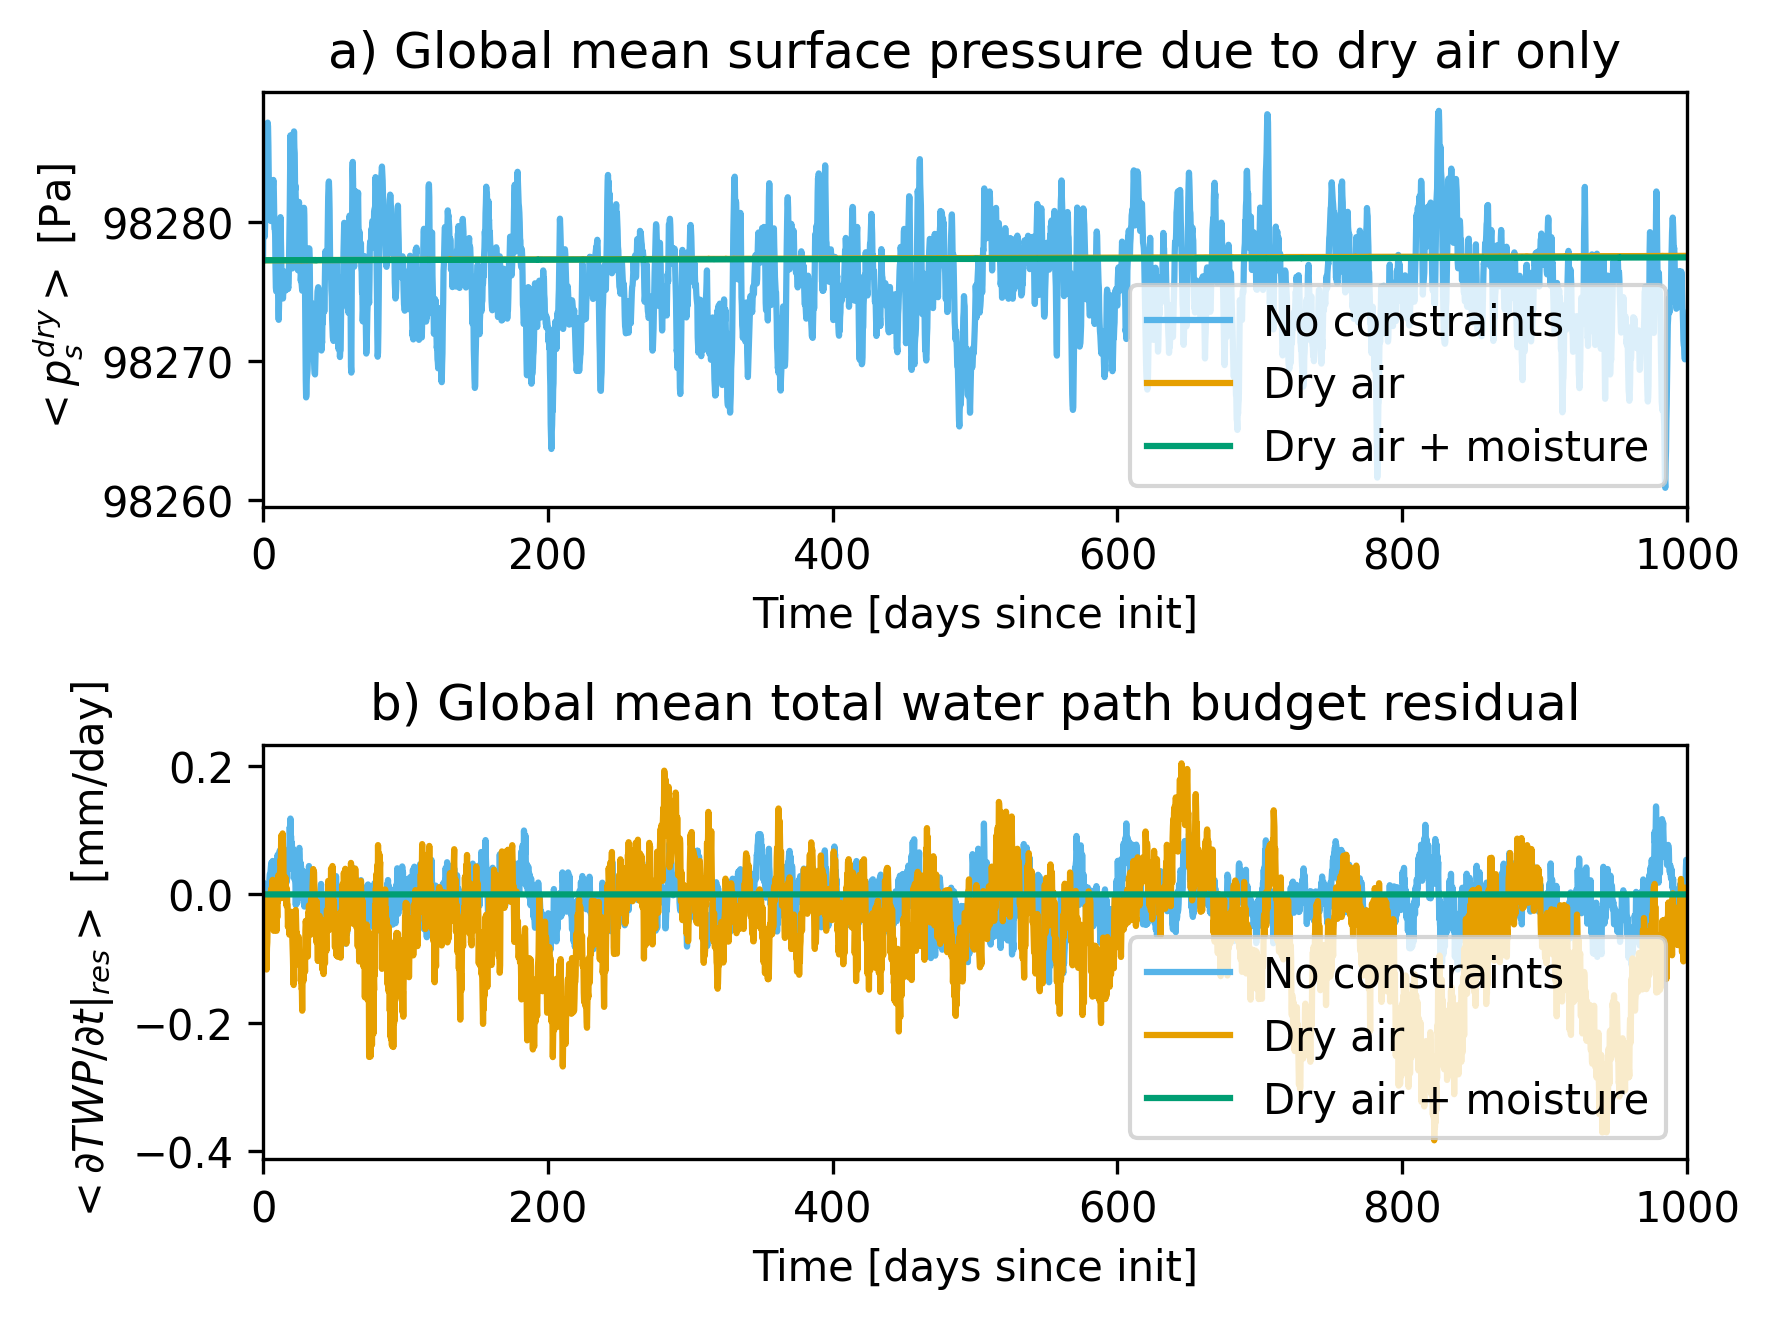

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4.5))
ds_timeseries.surface_pressure_due_to_dry_air.plot(ax=axes[0], hue='run')
ds_timeseries.total_water_path_budget_residual.plot(ax=axes[1], hue='run')
titles = ['a) Global mean surface pressure due to dry air only', 'b) Global mean total water path budget residual']
for i, ax in enumerate(axes):
    legend = ax.get_legend()
    legend.set_title('')
    legend.set_loc('lower right')
    ax.set_title(titles[i])
    ax.set_xlim([0, 1000])
fig.tight_layout()
fig.savefig('figures/shield_constraint_ablations_timeseries.png', dpi=300, transparent=True)


## Plot time-mean metrics

In [9]:
variables_to_plot = ['PRESsfc', 'total_water_path', 'PRATEsfc', 'evaporation']

In [10]:
def barplots(axes, df, variables, metric, metric_label, subplot_labels, show_xticklabels=True):
    for i, variable in enumerate(variables):
        seaborn.barplot(df, x='run', y=f'{metric}/{variable}', ax=axes[i], errorbar=lambda x: (x.min(), x.max()))
        axes[i].set_title(subplot_labels[i] + ' ' + LONG_NAMES[variable], fontsize=9)
        axes[i].set_xlabel('')
        axes[i].set_ylabel(metric_label + f' [{UNITS[variable]}]', fontsize=9)
        axes[i].set_xticks(axes[i].get_xticks())
        xticklabels = axes[i].get_xticklabels()
        if not show_xticklabels:
            xticklabels = [''] * len(xticklabels)
        axes[i].set_xticklabels(xticklabels, rotation=75, fontsize=9)
        current_yticks = axes[i].get_yticks()
        if len(current_yticks) > 7:
            current_yticks = current_yticks[::2]
        axes[i].set_yticks(current_yticks)
        axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=9)

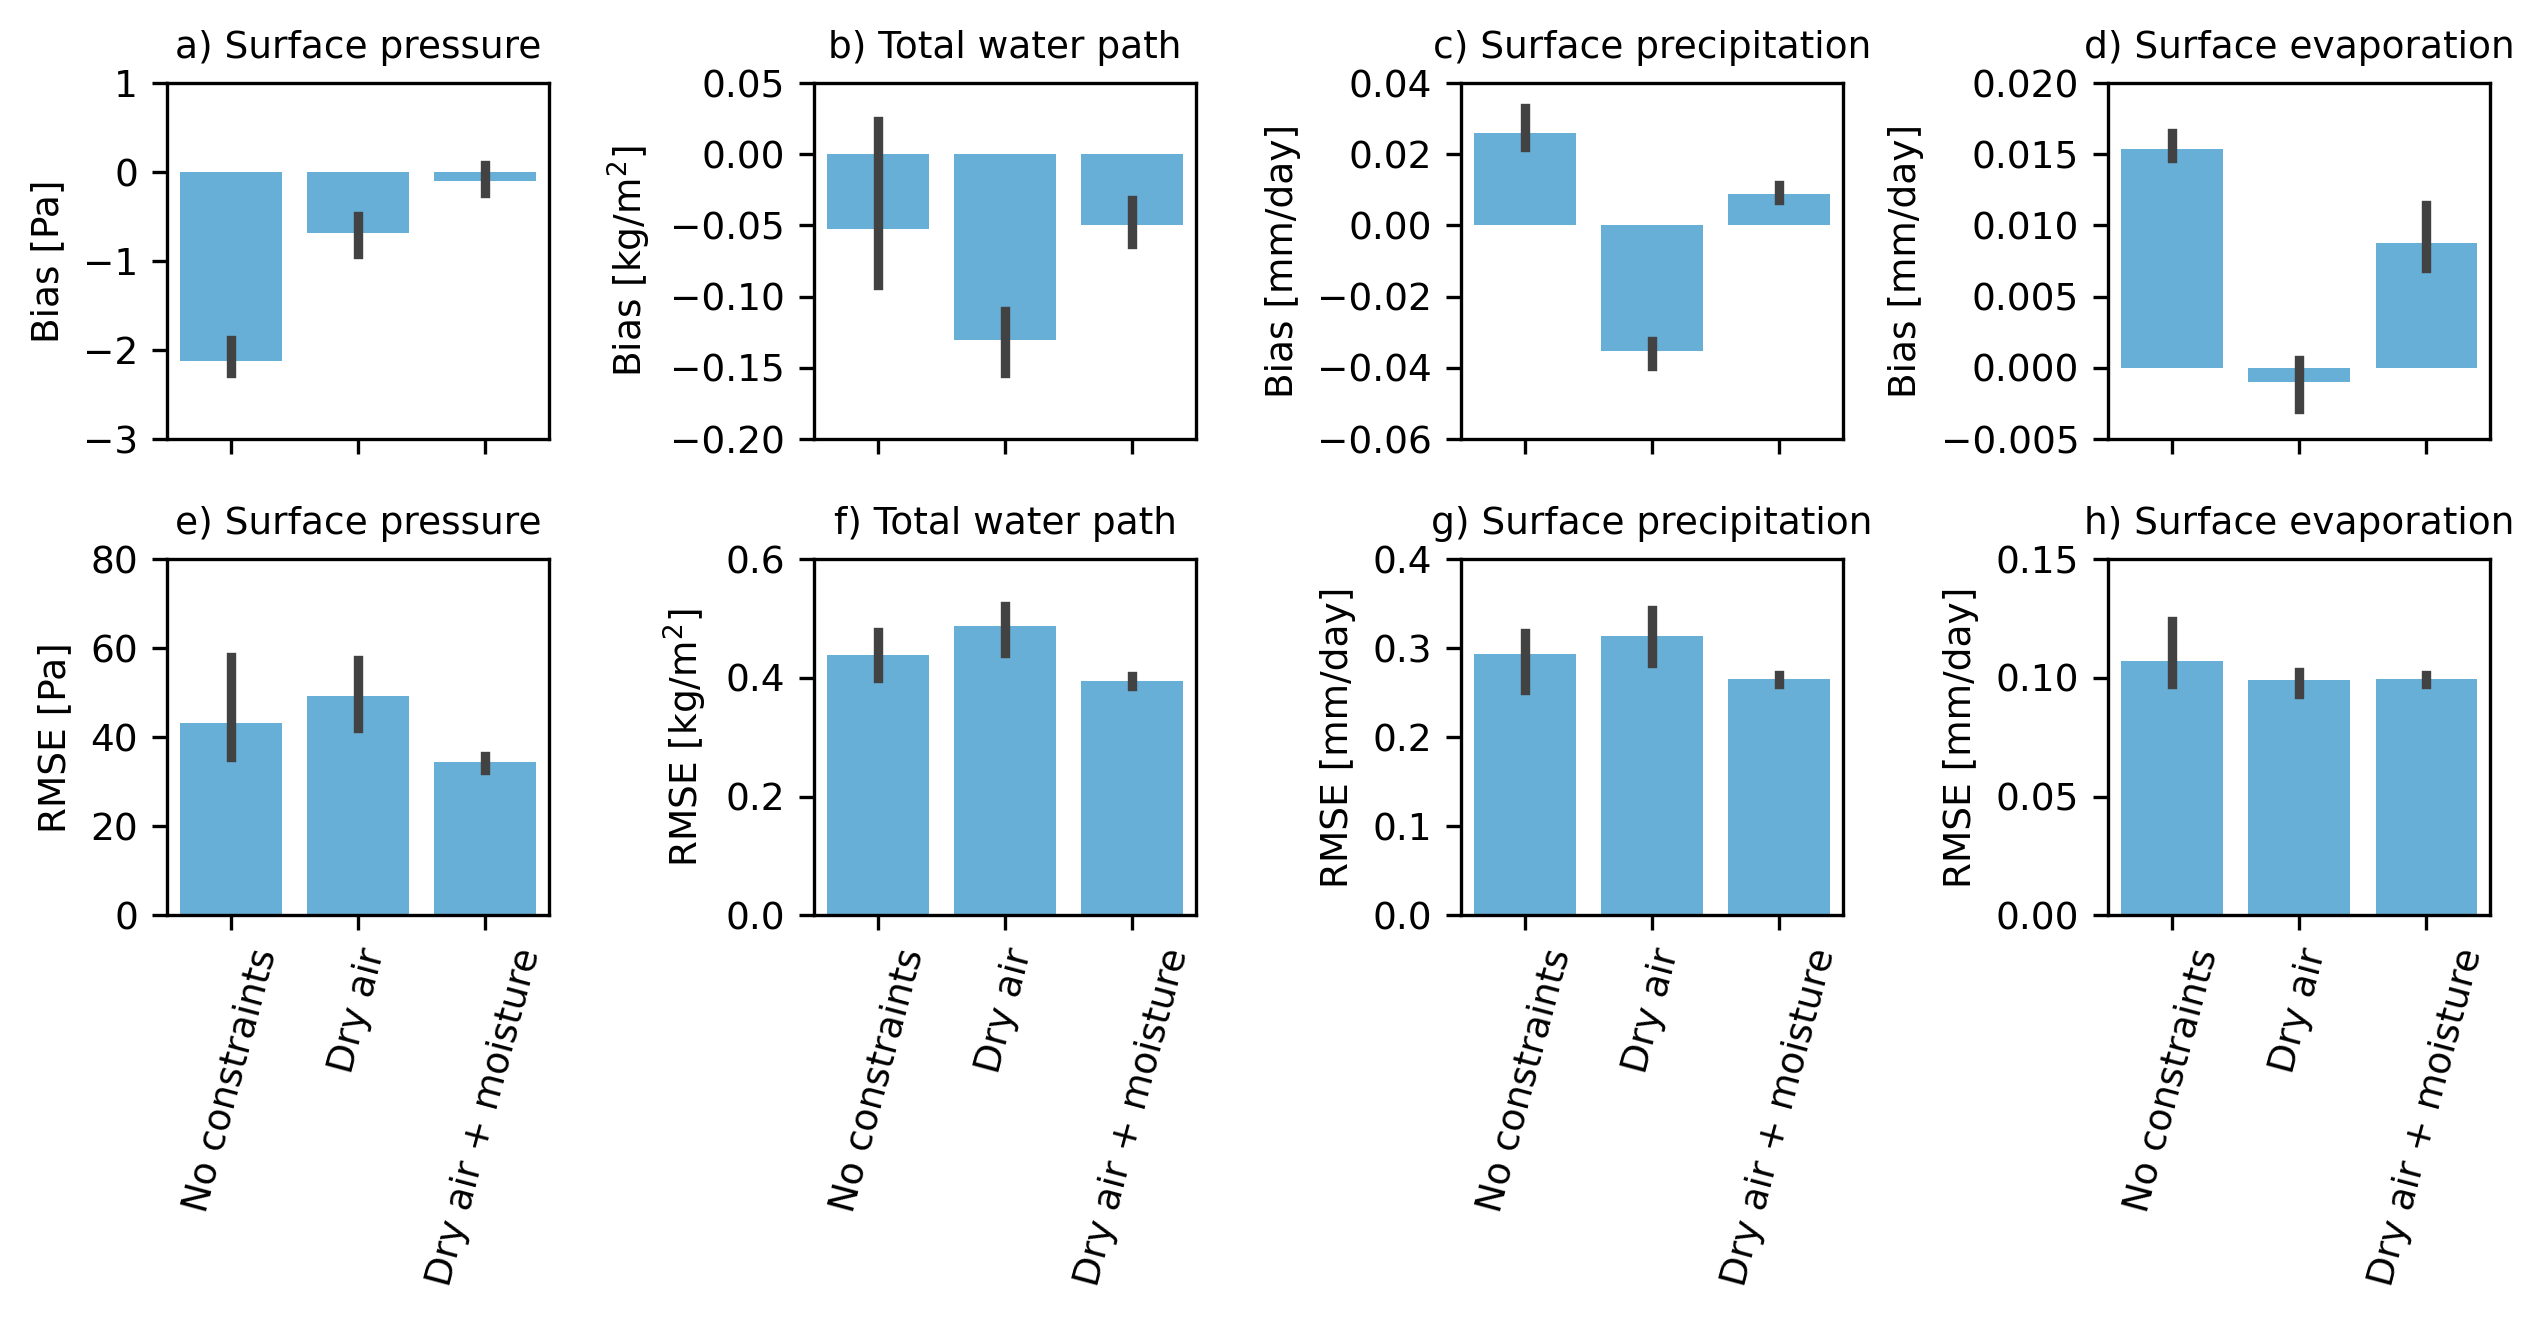

In [11]:
df = ds.to_dataframe()
fig, axes = plt.subplots(2, 4, figsize=(8.5, 4.5))
barplots(axes[0], df, variables_to_plot, 'bias', 'Bias',['a)', 'b)', 'c)', 'd)'], show_xticklabels=False)
barplots(axes[1], df, variables_to_plot, 'rmse', 'RMSE', ['e)', 'f)', 'g)', 'h)'])
fig.tight_layout()
fig.savefig('figures/shield_constraint_ablations_time_mean_bias_and_rmse.png', dpi=300, transparent=True)

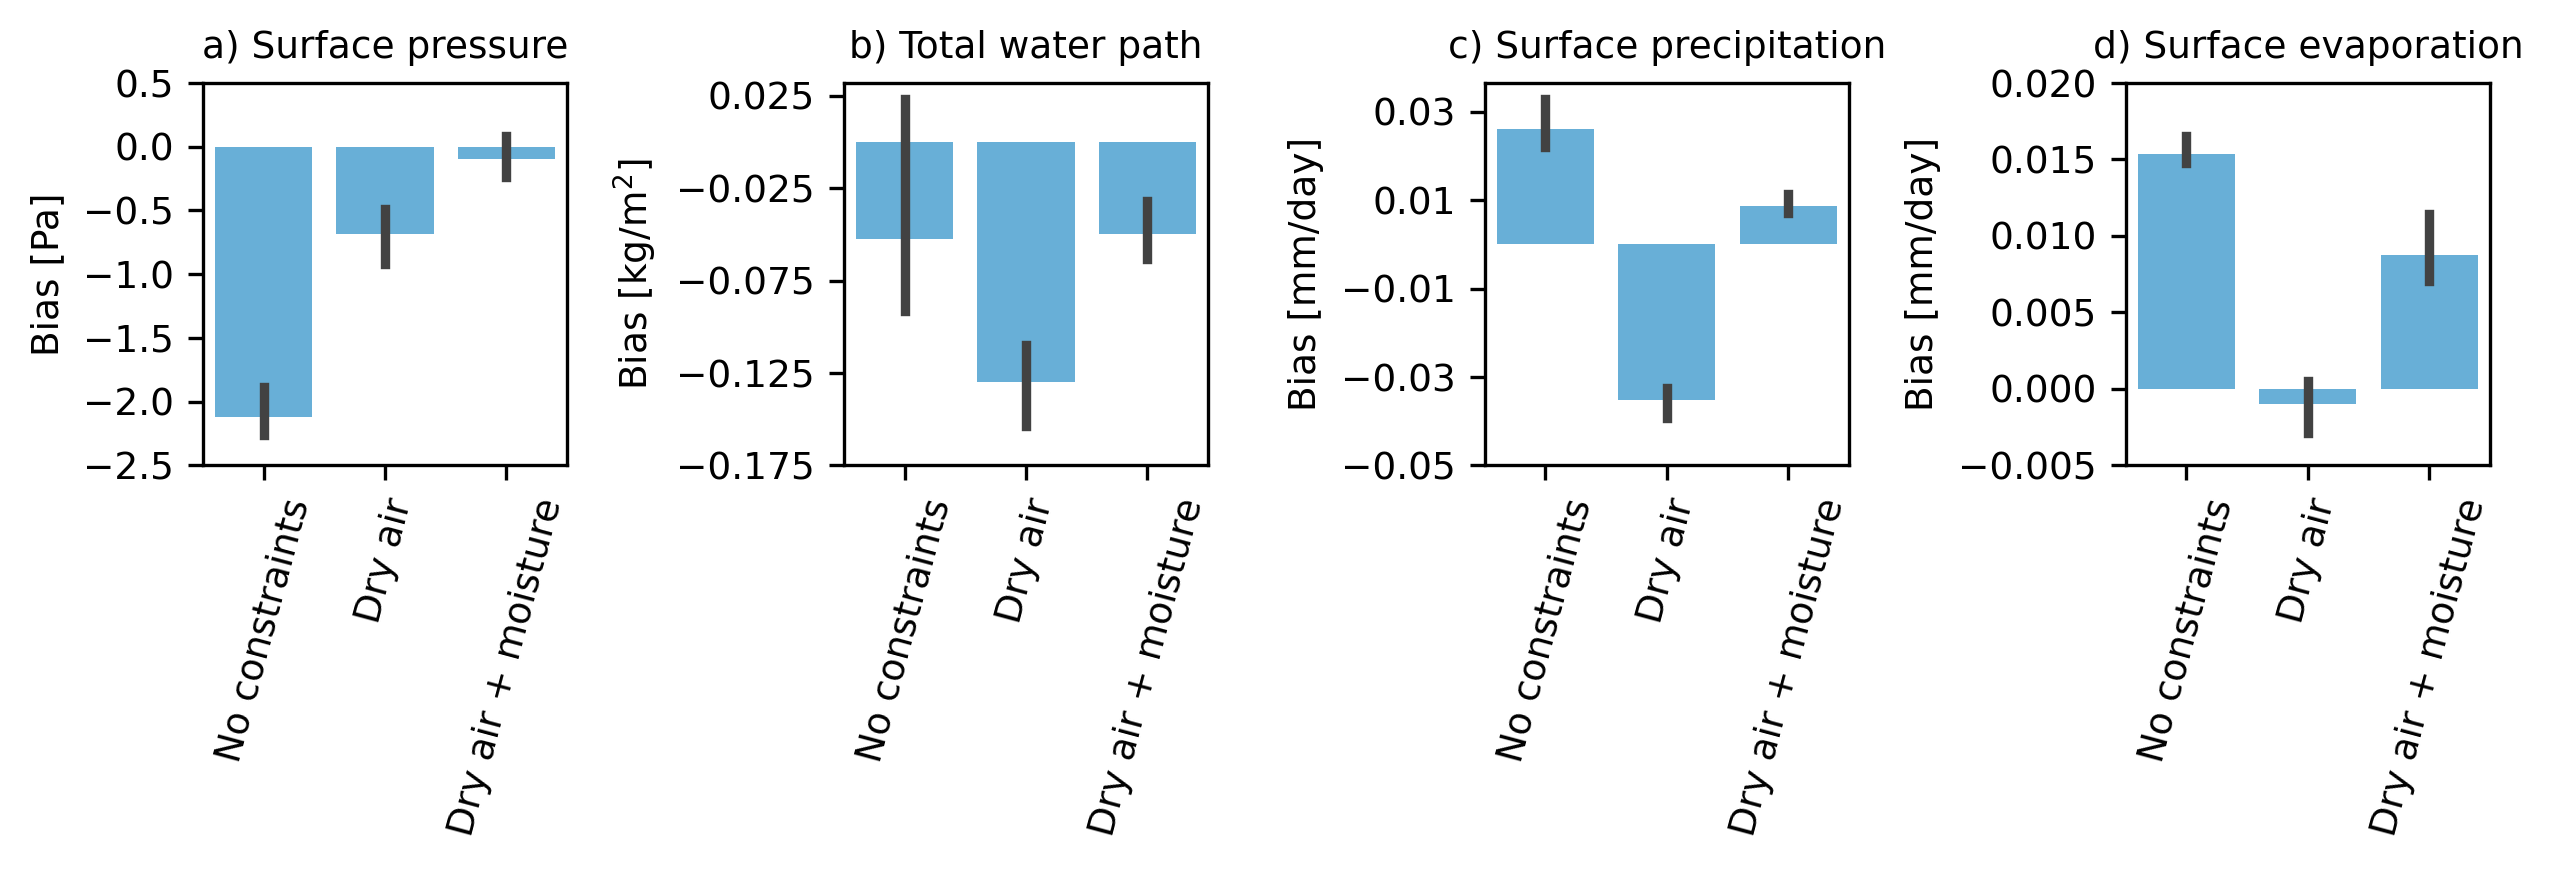

In [12]:
df = ds.to_dataframe()
fig, axes = plt.subplots(1, 4, figsize=(8.5, 3))
barplots(axes, df, variables_to_plot, 'bias', 'Bias',['a)', 'b)', 'c)', 'd)'])
fig.tight_layout()
fig.savefig('figures/shield_constraint_ablations_time_mean_bias.png', dpi=300, transparent=True)

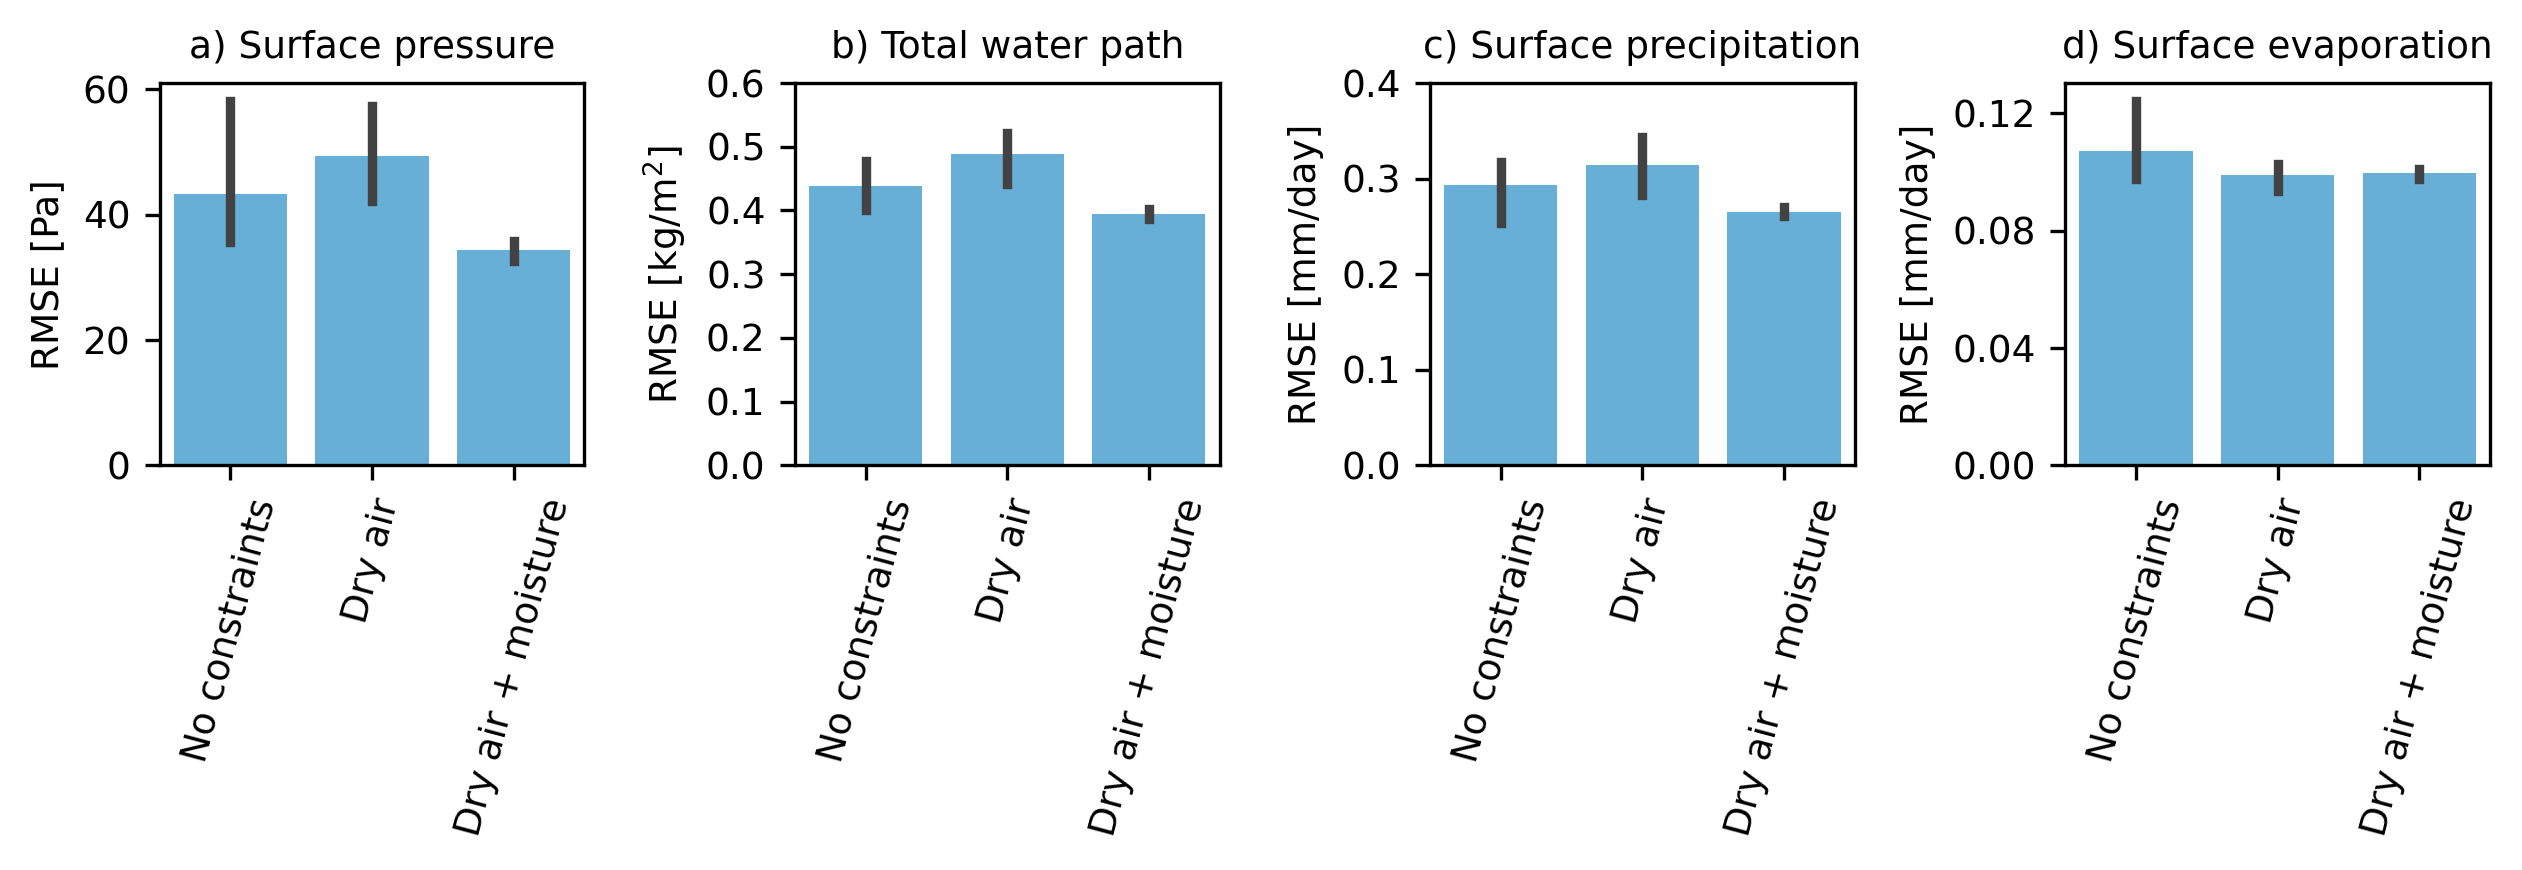

In [13]:
df = ds.to_dataframe()
fig, axes = plt.subplots(1, 4, figsize=(8.5, 3))
barplots(axes, df, variables_to_plot, 'rmse', 'RMSE',['a)', 'b)', 'c)', 'd)'])
fig.tight_layout()
fig.savefig('figures/shield_constraint_ablations_time_mean_rmse.png', dpi=300, transparent=True)